# Settings

In [ ]:
# import 
import numpy as np
import math
import matplotlib.pyplot as plt
import os

from scipy.spatial.transform import Rotation as R
from scipy import optimize
import time, datetime

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K

In [ ]:
# define 
phi = np.radians(np.linspace(0,45,100+1))
phi, phi.shape,len(phi)

# Common functions

In [1]:



plt.style.use('default')


def draw_standard_triangle(polar=False, dpi=80, figsize=None):
    """Draw Standard stereographic triangle."""
    # Plot data
    phi = np.radians(np.linspace(0,45,100+1))
    r = -np.cos(phi) + np.sqrt(np.power(np.cos(phi),2)+1) #101 to 111
    phi = np.hstack((0,phi,0)); r = np.hstack((0,r,0))
    x = r*np.cos(phi); y = r*np.sin(phi)
    x0, y0 = (0, 0)
    x1, y1 = (x[1], y[1])
    x2, y2 = (x[-2], y[-2])
    
    # Get Figure
    plt.style.use('default')
    if os.path.exists('IPF.mplstyle'):
        plt.style.use('IPF.mplstyle')
    projection = 'polar' if polar else None
    fig, axes = plt.subplots(subplot_kw=dict(projection=projection),
                             dpi=dpi, figsize=figsize, squeeze=False)
    ax = axes[0,0]
    ax.set_aspect('equal')
    if polar:
        plt.axis('off')
        ax.set_thetalim(0, math.radians(45))
    
    # Draw triangle
    u = phi if polar else x
    v = r if polar else y
    ax.plot(u, v, 'k-', zorder=0)
    
    def pos(x,y,polar):
        if polar:
            return math.atan2(y,x), np.linalg.norm([x,y])
        else:
            return x,y

    v_list = ['001','101','111']
    x_list = [x0-0.005, x1+0.005, x2]
    y_list = [y0, y1, y2+0.005]
    c_list = ['red', 'green', 'blue']
    ha_list = ['right','left','left']
    va_list = ['top','top','bottom']
    for v,x,y,c,ha,va in zip(v_list,x_list,y_list,c_list,ha_list,va_list):
        ax.text(*pos(x,y,polar),v, size=11, c=c, ha=ha, va=va)    

    return fig, ax


class ColormapInSST:
    """
    Color map in standard stereographic triangle (SST).
    """
    """ Vertices """
    x0 = 0; x1 = np.sqrt(2)-1; x2 = (np.sqrt(3)-1)/2
    p0 = np.array([0,0]); p1 = np.array([x1, 0]); p2 = np.array([x2, x2])
    pG = (p0+p1+p2)/3
    
    """ Segments """
    m0 = p0 - pG; m1 = p1 - pG; m2 = p2 - pG
    s0 = p1 - p0; s2 = p0 - p2
    
    def __init__(self):
        #self.fig, self.ax = draw_standard_triangle()
        distance = lambda p, s, ps: np.abs(np.cross(s,p-ps))/np.linalg.norm(s)
        self.L_P0_M1 = distance(self.p0, self.m1, self.pG)
        self.L_P0_M2 = distance(self.p0, self.m2, self.pG)
        self.L_P1_M2 = distance(self.p1, self.m2, self.pG)
        self.L_P1_M0 = distance(self.p1, self.m0, self.pG)
        self.L_P2_M0 = distance(self.p2, self.m0, self.pG)
        self.L_P2_M1 = distance(self.p2, self.m1, self.pG)

        self.L_PG_S0 = distance(self.pG, self.s0, self.p0)
        self.L_PG_S2 = distance(self.pG, self.s2, self.p2)
    
    def get_RGB(self, p:list):
        p = np.array(p)
        is_inside = ((p[0]+1)**2+p[1]**2<=np.sqrt(2)**2
                      and p[1]<=p[0] and p[1]>=0)
        
        """ Open self """
        p0,p1,p2,pG = self.p0,self.p1,self.p2,self.pG
        points = [p0,p1,p2,pG]
        
        """ Functions """
        is_above = lambda p, v: 1/np.divide(*(pG-v))*(p[0]-pG[0])+pG[1]<=p[1]
        distance = lambda p, s, ps: np.abs(np.cross(s,p-ps))/np.linalg.norm(s)
        slope = 1/np.divide(*(pG-p))
        def f(x):
            y  = (x+1)**2-2 + (slope*(x-pG[0])+pG[1])**2
            dy = 2*(x+1) + 2*y*slope
            ddy = 2 + 2*slope**2
            return y, dy, ddy
        
        """ In case : p is at P0, P1, P2, or PG """        
        if not is_inside:
            self.RGB = [1,1,1]
        elif np.any(p.tolist()==points):
            points = np.vstack(points).tolist()
            RGB_on_v = [[1,0,0],[0,1,0],[0,0,1],[1,1,1]]
            self.RGB = RGB_on_v[points.index(p.tolist())]
        else:
            """ Otherwise """
            s0, s2 = self.s0, self.s2
            m0, m1, m2 = self.m0, self.m1, self.m2

            if is_above(p,p2) and not is_above(p,p1): # in mainR:
                r = 1
                if not is_above(p, p0): # in sub0
                    g = 1 - distance(p, m2, pG)/self.L_P0_M2
                    b = distance(p, s0, p0)/self.L_PG_S0
                else: # in sub2:
                    b = 1 - distance(p, m1, pG)/self.L_P0_M1
                    g = distance(p, s2, p2)/self.L_PG_S2
            elif not is_above(p,p0) and not is_above(p,p2):  # in mainG:
                g = 1
                if not is_above(p, p1): # in sub0:
                    r = 1 - distance(p, m2, pG)/self.L_P1_M2
                    b = distance(p, s0, p0)/self.L_PG_S0
                else: # in sub1:
                    b = 1 - distance(p, m0, pG)/self.L_P1_M0
                    sol = optimize.root_scalar(f, x0=0.35, fprime=True,
                                               fprime2=True, method='halley')
                    x_sol = np.max(sol.root)
                    px = np.array([x_sol, slope*(x_sol-pG[0])+pG[1]])
                    r = np.linalg.norm(p-px)/np.linalg.norm(pG-px)
            else: # in mainB:
                b = 1
                if not is_above(p, p2): # in sub1:
                    g = 1 - distance(p, m0, pG)/self.L_P2_M0
                    sol = optimize.root_scalar(f, x0=0.35, fprime=True,
                                               fprime2=True, method='halley')
                    x_sol = np.max(sol.root)
                    px = np.array([x_sol, slope*(x_sol-pG[0])+pG[1]])
                    r = np.linalg.norm(p-px)/np.linalg.norm(pG-px)                    
                else: # in sub2:
                    r = 1 - distance(p, m1, pG)/self.L_P2_M1
                    g = distance(p, s2, p2)/self.L_PG_S2
            self.RGB = [r,g,b]
        #self.ax.scatter(*p, color=self.RGB, edgecolors='k')
        return np.array(self.RGB)



def get_time_stamp(time_start):
    """
    Return time stamp to check progress.
    
    Parameter
    ---------
    time_start : float
        Start time obtained by time.time()
    
    Returns
    -------
    time_s : str
        stamp to show elapsed time.
    date_s : str
        stamp to show date.
    """
    time_elapsed = time.time() - time_start
    hour = int(time_elapsed//3600)
    hour_s = f'{hour} hour ' if hour>0 else ''
    min_s = f'{int(time_elapsed%3600//60)} min '
    sec_s = f'{str(int(time_elapsed%60)).zfill(2)} sec'
    time_s = f'{hour_s}{min_s}{sec_s}'
    date_s = datetime.datetime.now().strftime('%m-%d %H:%M:%S')
    return time_s, date_s


direction_dict = dict(ND=np.array([0,0,0,1]),
                      RD=np.array([0,1,0,0]),
                      TD=np.array([0,0,1,0]))


# Quaternion operation
def q_mul(q1, q2):
    q31 = q1[0]*q2[0] - q1[1]*q2[1] - q1[2]*q2[2] - q1[3]*q2[3]
    q32 = q1[0]*q2[1] + q1[1]*q2[0] + q1[2]*q2[3] - q1[3]*q2[2]
    q33 = q1[0]*q2[2] - q1[1]*q2[3] + q1[2]*q2[0] + q1[3]*q2[1]
    q34 = q1[0]*q2[3] + q1[1]*q2[2] - q1[2]*q2[1] + q1[3]*q2[0]
    return np.array([q31,q32,q33,q34])


def norm(q):
    return q/np.linalg.norm(q)


def inverse(q):
    return np.array([q[0],-q[1],-q[2],-q[3]])


def sym_q_list(q_f, type_rot='ipf'):
    rot_equiv = np.array([
        [1, 0, 0, 0],[0, 1, 0, 0],[0, 0, 1, 0],[0, 0, 0, 1],
        [0.5, 0.5, 0.5, 0.5],[-0.5, 0.5, 0.5, 0.5],
        [0.5, -0.5, 0.5, 0.5],[-0.5, -0.5, 0.5, 0.5],
        [0.5, 0.5, -0.5, 0.5],[-0.5, 0.5, -0.5, 0.5],
        [0.5, 0.5, 0.5, -0.5],[-0.5, 0.5, 0.5, -0.5],
        [1/math.sqrt(2), 1/math.sqrt(2), 0, 0],
        [-1/math.sqrt(2), 1/math.sqrt(2), 0, 0],
        [1/math.sqrt(2), 0, 1/math.sqrt(2), 0],
        [-1/math.sqrt(2), 0, 1/math.sqrt(2), 0],
        [1/math.sqrt(2), 0, 0, 1/math.sqrt(2)],
        [-1/math.sqrt(2), 0, 0, 1/math.sqrt(2)],
        [0, 1/math.sqrt(2), 1/math.sqrt(2), 0],
        [0, 1/math.sqrt(2), -1/math.sqrt(2), 0],
        [0, 0, 1/math.sqrt(2), 1/math.sqrt(2)],
        [0, 0, 1/math.sqrt(2), -1/math.sqrt(2)],
        [0, 1/math.sqrt(2), 0, 1/math.sqrt(2)],
        [0, -1/math.sqrt(2), 0, 1/math.sqrt(2)]
    ]) 
    if type_rot=='ipf': # Frame-rot.
        q_list_eq = np.array([q_mul(q_f, r) for r in rot_equiv])
    elif type_rot=='pf': # Vector-rot.
        q_list_eq = np.array([q_mul(r, q_f) for r in rot_equiv])
    q_list_eq = np.array([q if q[0]>=0 else -q for q in q_list_eq])
    return q_list_eq


def unique_q(q_f, type_rot='ipf'):
    q_list_eq = sym_q_list(q_f, type_rot)
    return q_list_eq[q_list_eq[:,0].argmax(axis=0)]


def rot_vector(q, v, type_rot='B'):
    v = np.array([0, *v])
    if type_rot=='A':
        return q_mul(q, q_mul(v, inverse(q)))[1:]
    elif type_rot=='B':
        return q_mul(inverse(q), q_mul(v, q))[1:]



def ori_sub_calc(q1,q2):
    qd = q_mul(q1, inverse(q2))
    qd_list = sym_q_list(qd)
    residual = 2*math.degrees(math.acos(qd_list[:,0].max(axis=0)))
    print('min_ori_sub')
    print(residual)
    return residual


def ipf_vector(q_in, direction='ND'):
    direction_dict = dict(ND=np.array([0,0,0,1]),
                          RD=np.array([0,1,0,0]),
                          TD=np.array([0,0,1,0]))
    c = direction_dict[direction]
    v = q_mul(q_mul(inverse(q_in),c), q_in)[1:]
    if v[-1]<0:
        v = -v
    return v


def stereographic(v, in_sst=False):
    """Return stereographic position."""
    if in_sst:
        y, x, z = np.sort(np.abs(v))
    else:
        x, y, z = v
    r = np.linalg.norm(v)
    xs, ys = np.array([x, y])/(r+abs(z))
    return xs, ys

def ipf_plot(q_in, direction='ND'):
    v = ipf_vector(q_in, direction)
    return stereographic(v, in_sst=False)

def ipf_color(v):
    xs, ys = stereographic(v, in_sst=True)
    cm = ColormapInSST()
    return cm.get_RGB([xs, ys])


def stereo_projection(hkl):
    y = hkl[2]/(hkl[1]+1)
    z = hkl[3]/(hkl[1]+1)
    return y,z


def draw_projection_plane():
    fig, ax = plt.subplots(figsize=(20,20))
    
    # Draw circle.
    cir_x = np.sin(np.radians(np.arange(-180,181,1)))
    cir_y = np.cos(np.radians(np.arange(-180,181,1)))
    ax.plot(cir_x,cir_y,color=[0,0,0])

    # Plot symmetric points.
    base_vec = np.array([
        [0,1, 0, 0],[0,0, 1, 0],[0,0, 0, 1],
        [0,0,-1, 0],[0,0, 0, -1],
        [0,1, 1, 0], [0,1, -1, 0],
        [0,1, 0,1], [0,1, 0,-1],
        [0,0,1,1],[0,0,-1,1],[0,0,1,-1],[0,0,-1,-1],
        [0,1,1,1],[0,1,-1,1],[0,1,1,-1],[0,1,-1,-1],
        [0,1,1,2],[0,1,-1,2],[0,1,1,-2],[0,1,-1,-2],
        [0,1,2,1],[0,1,2,-1],[0,1,-2,1],[0,1,-2,-1],
        [0,2,1,1],[0,2,-1,1],[0,2,1,-1],[0,2,-1,-1]])
    ss_list = np.sum(base_vec**2,axis=1)
    norm_list = np.sqrt(ss_list)
    base_vec_norm = np.array([base_vec/norm
                              for base_vec, norm
                              in zip(base_vec, norm_list)])
    base_yz = np.array([stereo_projection(v) for v in base_vec_norm])
    marker_dict = {1:"s", 2:"d", 3:"^", 6:"8"}
    marker_list = [marker_dict[ss] for ss in ss_list]

    for (y, z), marker in zip(base_yz, marker_list):
        ax.scatter(y, z, color=[0,0,0], s=200, marker=marker)
    return fig, ax


# Load trained model

In [3]:
#setting activation
folder = 'npy data/ver20201224'

#for learning: K2
wafers = [['K2', 'No200'],['K2', 'No450'],['K2', 'No700']]

#for predicting: K3
wafers_predict = [['K3', 'No250'],['K3', 'No450'],['K3', 'No545'],['K3', 'No650']]

In [4]:
#current data
lum60 = np.vstack([np.load(f'{folder}/lum_mean_{ingot}_{wafer_num}_60.npy') for ingot, wafer_num in wafers])
lum45 = np.vstack([np.load(f'{folder}/lum_mean_{ingot}_{wafer_num}_45.npy') for ingot, wafer_num in wafers])
lum30 = np.vstack([np.load(f'{folder}/lum_mean_{ingot}_{wafer_num}_30.npy') for ingot, wafer_num in wafers])
#for n=3
lum = np.array([lum60,lum45,lum30])
#for n=2
#lum = np.array([lum60,lum45])
#for n=1
#lum = np.array([lum60])

lum = lum.transpose(1,2,0)

#r
r = np.vstack([np.load(f'npy data/q_wxyz_asscipy_{ingot}_{wafer_num}.npy') for ingot, wafer_num in wafers ])
r = np.array([r0/L for r0,L in zip(r, np.linalg.norm(r, axis=1))])
r = r*np.sign(r[:,-1]).reshape(-1,1)


In [105]:
from scipy.spatial.transform import Rotation as R
import tensorflow as tf
import tensorflow.keras.backend as K

test_id = 79

tf.keras.backend.clear_session()

def l2normalize(x):
    x = K.l2_normalize(x, axis=1)
    return x


def get_model(type_model='lstm', model_id='test',test_id=None, ss=72):
    #複数仰角で学習
    if test_id in [5,8,12,13,14,15,19,24,25,26,43]:
        n = 2
    elif test_id in [9,16,23,27,31,32,33,34,35,36,37,38,39,62,70,71,72,73,74,75,76,77,78,79]:
        n = 3
    #一つの仰角で学習
    else:
        n = 1
    
    lum_shape = (ss, n)

    if model_id==0:        
        # x = tf.keras.layers.LSTM(units=128)(lum_input)
        model = tf.keras.Sequential([
            tf.keras.layers.LSTM(units=128, input_shape=lum_shape),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(4),
            tf.keras.layers.Activation(l2normalize)])
        return model
    
    elif model_id==1:
        model = tf.keras.Sequential([
            tf.keras.layers.LSTM(units=128, input_shape=lum_shape),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(4),
            tf.keras.layers.Activation(l2normalize)])
        return model
    
    elif model_id==2:
        model = tf.keras.Sequential([
            tf.keras.layers.LSTM(units=128, input_shape=lum_shape),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(4),
            tf.keras.layers.Activation(l2normalize)])
        return model        


# Setting
ss = 72
model_id = 0
type_model = ['lstm', 'conv1d'][0]

model=get_model(type_model=type_model,
                model_id=model_id, test_id = test_id,
                ss=ss)

model.summary()
tf.keras.backend.clear_session()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67584     
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
 activation (Activation)     (None, 4)                 0

In [106]:
import pickle, os
from sklearn.model_selection import train_test_split


def rotate_data(lum, r, N_lum=72, step=36):
    """
    Data augumentation by rotating data.
    """
    q_cubic = [[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1],
               [1,1,1,1], [-1,1,1,1], [1,-1,1,1], [-1,-1,1,1],
               [1,1,-1,1], [-1,1,-1,1], [1,1,1,-1], [-1,1,1,-1],
               [1,1,0,0], [-1,1,0,0], [1,0,1,0], [-1,0,1,0],
               [1,0,0,1], [-1,0,0,1], [0,1,1,0], [0,1,-1,0],
               [0,0,1,1], [0,0,1,-1], [0,1,0,1], [0,-1,0,1]]
    B_cubic = R.from_quat(np.roll(q_cubic,-1,axis=1)).inv()
    
    shift = np.arange(step, N_lum, step)
    lum_shifted = np.vstack([np.roll(lum, i, axis=1) for i in shift])
    
    theta_shift = 2*math.pi*shift/N_lum
    r_shift = np.array([[0, 0, z, w] for w, z in zip(np.cos(-theta_shift/2), np.sin(-theta_shift/2))])
    B_shift = R.from_quat(r_shift)

    B = R.from_quat(np.roll(r, -1, axis=1)).inv()
    
    r_shifted = np.vstack([(Bi*B).reduce(right=B_cubic).inv().as_quat() for Bi in B_shift])
    r_shifted = np.roll(r_shifted, 1, axis=1)
    r_shifted = r_shifted * np.sign(r_shifted[:,0]).reshape(-1,1)
    
    return lum_shifted, r_shifted


# Settin
test_id = 79
#seed_rand = [1234, 1234]
seed_rand = [111, 222, 333, 444, 555, 666, 777, 888, 999, 1111]
data_augmentation = False
step_aug = 24


# Passive setting
result_folder = f'results/all/{test_id}'
tf.random.set_seed(seed_rand[9])

model = get_model(type_model=type_model,
                  model_id=model_id, test_id = test_id,
                  ss=ss)


#if test_id in [3,6]:
#    lum = lum[:,:,1].reshape(-1,72,1)
#elif test_id in [4,7]:
#    lum = lum[:,:,0].reshape(-1,72,1)


(lum_train, lum_valid, r_train, r_valid) = train_test_split(lum, r, train_size=0.8,
                                                          random_state=seed_rand[9])


if os.path.exists(f'{result_folder}/weight_all.hdf5'):
    model.load_weights(f'{result_folder}/weight_all.hdf5')
else:
    print(f'test id : {test_id} has no weights')



step = 9
N_lum = lum.shape[1]
print(N_lum)
lum_shifted, r_shifted = rotate_data(lum_train, r_train, N_lum=N_lum, step=step)

lum_shifted.shape[0]/(72/step-1), r_shifted.shape[0]/(72/step-1)

test id : 79 has no weights
72


(3838.0, 3838.0)

Start | 0 min 00 sec | 02-11 14:44:23
Data shape : lum : (4798, 72, 3), r : (4798, 4)
Data size | Train : 3838, Valid : 960
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67584     
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 516      

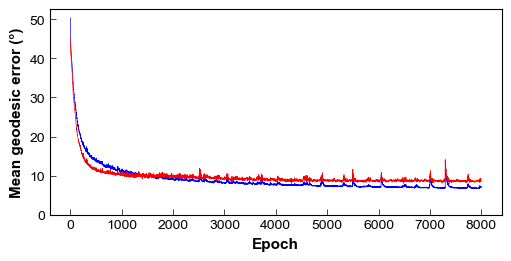

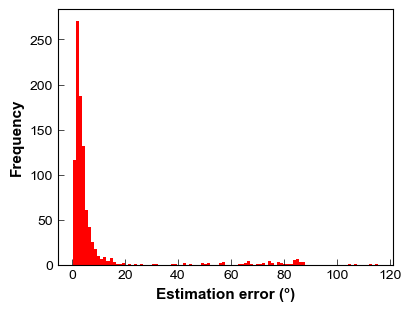

In [107]:
import pickle, os
from sklearn.model_selection import train_test_split
import time
from scipy.spatial.transform import Rotation as R

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K


def pickle_object(obj, path):
    with open(path,"wb") as f:
        pickle.dump(obj, f)


def geodesic_distance(y_true, y_pred):
    """Return mean geodesic distance in radian."""
    y_pred = K.l2_normalize(y_pred, axis=1)
    yy = K.sum(y_true*y_pred, axis=1)
    z = 1-1e-6
    mgd = K.mean(2*tf.acos(K.abs(K.clip(yy,-z,z))))
    return mgd


# Setting
test_id = 79
#seed_rand = [1234, 1234]
seed_rand = [111, 222, 333, 444, 555, 666, 777, 888, 999, 1111]
data_augmentation = False
step_aug = 1

type_loss = ['distance', '1st', '2nd'][0]

ss = ss 
type_model = type_model

plt.style.use('default')
plt.style.use('normal.mplstyle')


# Passive setting
result_folder = f'results/all/{test_id}'
tf.random.set_seed(seed_rand[9])
os.makedirs(result_folder)
report = open(f'results/all/{test_id}_all.txt', mode='w')


# Report Starting Status
for item, value in zip(['data', 'model', 'loss', 'seed'],
                       [folder, type_model, type_loss, seed_rand]):
    report.write(f'{item} : {value}'); report.write('\n')


def geodesic_loss(y_true, y_pred):
    y_pred = K.l2_normalize(y_pred, axis=1)
    yy = K.sum(y_true*y_pred, axis=1)
    z = 1-1e-6
    yy = K.clip(yy,-z,z)
    
    if type_loss=='distance':
        loss = 2*tf.acos(K.abs(yy))
    elif type_loss=='1st':
        loss = 1 - K.abs(yy)
    elif type_loss=='2nd':
        loss = 1 - yy**2
    return K.mean(loss)



time_start = time.time()    
time_s, date_s = get_time_stamp(time_start)
report_time = f'Start | {time_s} | {date_s}'
print(report_time)
report.write(report_time); report.write('\n')


if test_id in [3,6]:
    lum = lum[:,:,1].reshape(-1,72,1)
elif test_id in [4,7]:
    lum = lum[:,:,0].reshape(-1,72,1)
    
(lum_train, lum_valid, r_train, r_valid) = train_test_split(lum, r, train_size=0.8,
                                                          random_state=seed_rand[9])

report_shape = f'Data shape : lum : {lum.shape}, r : {r.shape}'
report_size = f'Data size | Train : {len(lum_train)}, Valid : {len(lum_valid)}'
print(report_shape)
print(report_size)
report.write(report_shape); report.write('\n')
report.write(report_size); report.write('\n')


if data_augmentation:
    N_lum = lum_train.shape[1]
    lum_shifted, r_shifted = rotate_data(lum_train, r_train, N_lum=N_lum, step=step_aug)

    if True:
        lum_train = np.vstack([lum_train, lum_shifted])
        r_train = np.vstack([r_train, r_shifted])
    else: # for test
        lum_train = lum_shifted
        r_train = r_shifted
    report_augmentation = f'Augmentation step : {step_aug}, Augmented size | Train : {len(lum_train)}, Valid : {len(lum_valid)}'
    print(report_augmentation)
    report.write(report_augmentation); report.write('\n')

    
#model summary
model.summary()
print(lum_train.shape, lum_valid.shape)


# Prefit
epochs = 20
batch_size = 1919
#batch_size = 959*16 # 3836==4*7*137, 7*137==959

tf.keras.backend.clear_session()
model_pre = get_model(type_model=type_model,
                      model_id=model_id, test_id = test_id,
                      ss=ss)
model_pre.compile(loss="mae", optimizer='adam',
                  metrics=[geodesic_distance])
history_pre = model_pre.fit(x=lum_train, y=r_train,
                            validation_data=(lum_valid, r_valid),
                            batch_size=batch_size, epochs=epochs,
                            verbose=0) # 0 = silent, 1 = progress bar, 2 = one line per epoch.
model_pre.save_weights(f'{result_folder}/weight_pre_all.hdf5')
pickle_object(history_pre.history, f'{result_folder}/history_pre_all.pickle')
pickle_object(history_pre.params, f'{result_folder}/params_pre_all.pickle')

# Report 1
for item, value in zip(['epochs', 'batch_size'], [epochs, batch_size]):
    report.write(f'{item} : {value}'); report.write('\n')
time_s, date_s = get_time_stamp(time_start)
report_time = f'Initialized | {time_s} | {date_s}'
print(report_time)
report.write(report_time); report.write('\n')


# Fit
epochs = 8000
batch_size = 1919*2 # 3836==4*7*137, 7*137==959

for item, value in zip(['epochs', 'batch_size'], [epochs, batch_size]):
    report.write(f'{item} : {value}'); report.write('\n')

clipnorm = None 
optimizer = tf.keras.optimizers.Adam() # 0.0001

model = get_model(type_model=type_model,
                  model_id=model_id, test_id =test_id,
                  ss=ss)
model.compile(loss=geodesic_loss, optimizer=optimizer,
              metrics=[geodesic_distance])
model.load_weights(f'{result_folder}/weight_pre_all.hdf5')



# To restore best weights
#checkpoint_filepath = '/temp/checkpoint'
checkpoint_filepath = r'C:/Users/kyokahara/Python Work/CO estimation/temp/checkpoint/model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='geodesic_distance',
    mode='min',
    save_best_only=True)

history = model.fit(x=lum_train, y=r_train,
                    validation_data=(lum_valid, r_valid),
                    batch_size=batch_size, epochs=epochs,
                    callbacks=[model_checkpoint_callback],
                    verbose=0)

model.load_weights(checkpoint_filepath)
model.save_weights(f'{result_folder}/weight_all.hdf5')
pickle_object(history.history, f'{result_folder}/history_all.pickle')
pickle_object(history.params, f'{result_folder}/params_all.pickle')

# Report 2-1 : Learning curve
fig, ax = plt.subplots(figsize=(5,2.5))
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean geodesic error (°)')
yt = np.array(history.history['geodesic_distance'])*180/math.pi
yv = np.array(history.history['val_geodesic_distance'])*180/math.pi        
ax.plot(yt, 'b-', ms=1, lw=0.5)
ax.plot(yv, 'r-', ms=1, lw=0.5)
ax.set_ylim(0,None)
fig.savefig(f'{result_folder}/learning_curve_all.png', dpi=100)

time_s, date_s = get_time_stamp(time_start)

report_time = f'Done | {time_s} | {date_s}'
report_data = f'- Train: {yt[-1]:.2f}°, Validation: {yv[-1]:.2f}° -'
print(report_time)   
print(report_data)
report.write(report_time); report.write('\n')
report.write(report_data); report.write('\n')


# Predict
pred_r = model.predict(lum_valid)
pred_norm = np.linalg.norm(pred_r, axis=1)
pred_r0 = np.array([r/norm for r, norm in zip(pred_r, pred_norm)])

gde_list = np.degrees(2*np.arccos(np.abs(np.sum(pred_r0*r_valid, axis=1))))
fig, ax = plt.subplots(figsize=(4,3))
ax.set_xlabel('Estimation error (°)')
ax.set_ylabel('Frequency')
plt.hist(gde_list, 100)
fig.savefig(f'{result_folder}/histogram_all.png', dpi=100)

# Report 2-2
report_data_mean = f'Mean GDE : {np.mean(gde_list):.2f}°'
report_data_median = f'Median of GDE : {np.median(gde_list):.2f}°'
print(report_data_mean)
print(report_data_median)
report.write(report_data); report.write('\n')


# Report 3
report.write('\n\n# Model')
model.summary(print_fn=lambda x: report.write(x + "\r\n"))
report.write('\n\n# Parameters')
for p in history.params.items():
    line = [p[0], str(p[1])]
    report.writelines(['\n', ' : '.join(line)])
report.close()

print(f'Finished test_id : {test_id}')
print(history.params)

# Predict

-- Test --
Mean GDE : 8.40°
Median of GDE : 4.51°
[8.42473386 4.51123323 2.7277644 ]
8.399810681610681 10.586923187632157
-- Validation --
Mean GDE : 5.44°
Median of GDE : 3.16°
[5.25645727 3.15577445 2.09595563]
5.43981094074094 7.915478523802156


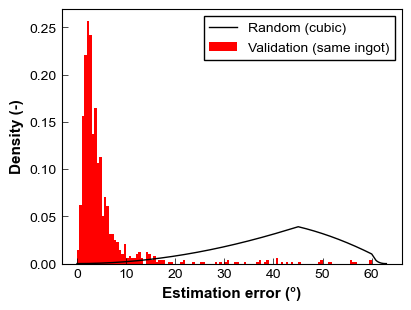

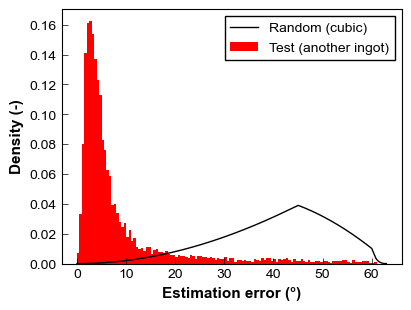

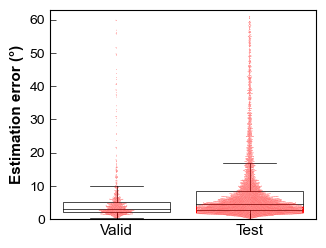

In [108]:
from scipy.spatial.transform import Rotation as R
import numpy as  np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


def random_misorientations(deg):
    """
    Return theoretical random misorientation distrbution density.
    ---------
    Reference
    ---------
    D. C. Handscomb, Can. J. Math. 10, 85 (1958). 
    https://doi.org/10.4153/CJM-1958-010-0
    """
    d = np.radians(deg)
    if deg < 45:
        eq = 2/15*(1-np.cos(d))
    elif deg < 60:
        eq = 2/15*(3*(np.sqrt(2)-1)*np.sin(d) - 2*(1-np.cos(d)))
    elif deg < 2*np.degrees(np.arctan(2-np.sqrt(2))): # = 60.72∘
        eq = 2/15*((3*(np.sqrt(2)-1)+4/np.sqrt(3))*np.sin(d)-6*(1-np.cos(d)))
    elif deg < np.degrees(np.arccos(1/4*(2*np.sqrt(2)-1))): # = 62.80∘
        cot = 1/np.tan(d/2)
        t1 = cot**2/(3+2*np.sqrt(2)-cot**2)
        t2 = (cot**2-2*np.sqrt(2))/(3-cot**2)
        t3 = (np.sqrt(2)-1)*cot/np.sqrt(1-(np.sqrt(2)-1)**2*cot**2)
        t4 = (np.sqrt(2)-1)**2*cot/np.sqrt(3-cot**2)
        eq = 2/15*((3*(np.sqrt(2)-1)+4/np.sqrt(3))*np.sin(d) - 6*(1-np.cos(d)))\
            +8/(5*np.pi)*(1-np.cos(d))*(np.arccos(t1) + 1/2*np.arccos(t2))\
            -8/(5*np.pi)*np.sin(d)*(2*(np.sqrt(2)-1)*np.arccos(t3) + 1/np.sqrt(3)*np.arccos(t4))
    else:
        eq = 0
    return eq


def predict_B(lum, model):
    r = model.predict(lum)
    r = r/np.linalg.norm(r, axis=1).reshape(-1,1)    
    B = R.from_quat(np.roll(r, -1, axis=1)).inv()
    return B


def get_estimation_error(lum, r, model):
    q_cubic = [[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1],
               [1,1,1,1], [-1,1,1,1], [1,-1,1,1], [-1,-1,1,1],
               [1,1,-1,1], [-1,1,-1,1], [1,1,1,-1], [-1,1,1,-1],
               [1,1,0,0], [-1,1,0,0], [1,0,1,0], [-1,0,1,0],
               [1,0,0,1], [-1,0,0,1], [0,1,1,0], [0,1,-1,0],
               [0,0,1,1], [0,0,1,-1], [0,1,0,1], [0,-1,0,1]]
    B_cubic = R.from_quat(np.roll(q_cubic,-1,axis=1)).inv()
    #B_cubic = R.create_group('O')
    
    B_pred = predict_B(lum, model)
    B = R.from_quat(np.roll(r, -1, axis=1)).inv()
    mag = (B_pred.inv()*B).reduce(B_cubic).magnitude()*180/math.pi
    return mag


def draw_error_hist(mag, label, result_folder, savefig=True, name_fig='test'):
    theta_list = np.arange(0,63,0.02)
    rand_dist = np.array([random_misorientations(theta) for theta in theta_list])

    plt.style.use('default')
    plt.style.use('normal.mplstyle')
    fig, ax = plt.subplots(figsize=(4,3))

    hist = ax.hist(mag, bins=np.arange(0,63,0.5), density=True, label=label)
    plot = ax.plot(theta_list, rand_dist, 'k-', label='Random (cubic)', )
    
    ax.set_xlabel('Estimation error (°)')
    ax.set_ylabel('Density (-)')
    ax.legend()
    if savefig:
        fig.savefig(f'{result_folder}/histogram_reduced_{name_fig}.png', dpi=300)
    return fig, ax


# Predict
lum60_pre = np.vstack([np.load(f'{folder}/lum_mean_{ingot}_{wafer_num}_60.npy') for ingot, wafer_num in wafers_predict])
lum45_pre = np.vstack([np.load(f'{folder}/lum_mean_{ingot}_{wafer_num}_45.npy') for ingot, wafer_num in wafers_predict])
lum30_pre = np.vstack([np.load(f'{folder}/lum_mean_{ingot}_{wafer_num}_30.npy') for ingot, wafer_num in wafers_predict])
lum_pre = np.array([lum60_pre,lum45_pre,lum30_pre])
#lum_pre = np.array([lum60_pre,lum45_pre])
#lum_pre = np.array([lum60_pre])
lum_pre = lum_pre.transpose(1,2,0)
r_pre = np.vstack([np.load(f'npy data/q_wxyz_asscipy_{ingot}_{wafer_num}.npy') for ingot, wafer_num in wafers_predict ])
r_pre = np.array([r0/L for r0,L in zip(r_pre, np.linalg.norm(r_pre, axis=1))])
r_pre = r_pre*np.sign(r_pre[:,-1]).reshape(-1,1)
lum_test = np.copy(lum_pre)
r_test = np.copy(r_pre)


if test_id in [3,6]:
    lum_test = lum_test[:,:,1].reshape(-1,72,1) # for 45°
elif test_id in [4,7]:
    lum_test = lum_test[:,:,0].reshape(-1,72,1) # for 60°

#corrected
mag_test = get_estimation_error(lum_test, r_test, model)
mag_valid = get_estimation_error(lum_valid, r_valid, model)
label_valid = 'Validation (same ingot)'
fig, ax = draw_error_hist(mag_valid, label_valid, result_folder=result_folder, name_fig='K2')
label_test = 'Test (another ingot)'
fig, ax = draw_error_hist(mag_test, label_test, result_folder=result_folder, name_fig='K3')


mag = mag_test
print('-- Test --')

report_data_mean = f'Mean GDE : {np.mean(mag):.2f}°'
report_data_median = f'Median of GDE : {np.median(mag):.2f}°'
print(report_data_mean)
print(report_data_median)

print(np.percentile(mag, [75, 50, 25]))
print(np.mean(mag), np.std(mag))

mag = mag_valid
print('-- Validation --')
report_data_mean = f'Mean GDE : {np.mean(mag):.2f}°'
report_data_median = f'Median of GDE : {np.median(mag):.2f}°'
print(report_data_mean)
print(report_data_median)

print(np.percentile(mag, [75, 50, 25]))
print(np.mean(mag), np.std(mag))



# Box plot
df = pd.concat([pd.melt(pd.DataFrame({'Valid': mag_valid})),
               pd.melt(pd.DataFrame({'Test': mag_test}))])


cm = 1/2.54


fig, ax = plt.subplots(figsize=(8*cm, 6*cm))

sns.boxplot(x='variable', y='value', data=df, showfliers=False, ax=ax, color='w')
plt.setp(ax.artists, edgecolor='k', lw=0.5)
plt.setp(ax.lines, color='k', lw=0.5)

sns.swarmplot(x='variable', y='value', data=df, color='red', ax=ax, size=0.4)

plt.xticks(fontsize=11)
ax.set_xlabel(None)
ax.set_ylabel('Estimation error (°)')
ax.set_ylim([0,63])

fig.savefig(f'{result_folder}/boxplot.png', dpi=300)